# Projet 6 : Classifiez automatiquement des biens de consommation

Dans ce projet, il est demandé d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories.

Le jeu de données peut se télécharger à l'adresse suivante : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

Les données représentent 1050 images. Chaque image contient une description associée et est catégorisée suivant un système d'arbres. 

Les descriptions et les images numériques vont être traitées séparament et les features extraites de chacune des deux méthodes vont être concaténées pour effectuer une unique séparation visuelle.

#### Méthodologie pour les textes :

1) Vectoriser par Tf-idf

2) Vectoriser en Bag of Words puis appliquer LDA (Latent Dirichlet Allocation)

3) Vectoriser par Tf-idf puis appliquer NMF(Factorisation par matrices non négatives)
    
4) Word2Vec (Word Embedding par réseau de neurones)
    
5) Doc2Vec (Word Embedding par réseau de neurones)

#### Méthodologie pour les images :
    
1) Extraction des features par SIFT

2) Extraction des features par réseau de neurones (ResNet 50)

#### Méthodologie pour la segmentation des features

Chaque résultat issu de l'extraction des features textes et images est segmenté par k-means puis évalué par le score ARI. Ensuite toutes les combinaisons de features textes + images sont testées pour déterminer si l'association des deux, offre un meilleur résultat.

#### Chargement des librairies

In [1]:
# Librairies diverses
import os
import string
import pickle
import multiprocessing

# Outils mathématiques et manipulation de données
import pandas as pd
import numpy as np
import scipy as sp

# Librairies graphiques
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
from textwrap import wrap

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

# Traitement d'images
import cv2 
from PIL import Image, ImageOps
from PIL import ImageFilter
from glob import glob

# Nettoyage de texte
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict  # For word frequency
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from tqdm import tqdm
from bs4 import BeautifulSoup 
import re # For regular expressions
import spacy

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# Librairie de Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Metriques de Segmentation
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix

# Réduction de dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# Transfert Learning
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.python.keras import Model, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Modèles word2vec et doc2vec
from gensim.models import Word2Vec
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument

#### Chargement des données

In [3]:
# Chemin d'accès aux données images
path = "D:/OpenClassRoom/Projet_6/"
# Lecture du fichier csv
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

## 1. Description des données

#### 1.1 Apperçu des données

In [4]:
# Affichage des 5 premières lignes
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Chaque ligne correspond à une image, avec son nom et ses caractéristiques associées telle qu'une description, la catégorie du produit etc...

Le nom de l'image permet d'aller la récupérer facilement dans les dossiers pour une lecture simplifiée

#### 1.2 Structure des données

In [5]:
# Structure des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

#### 1.3 Données manquantes

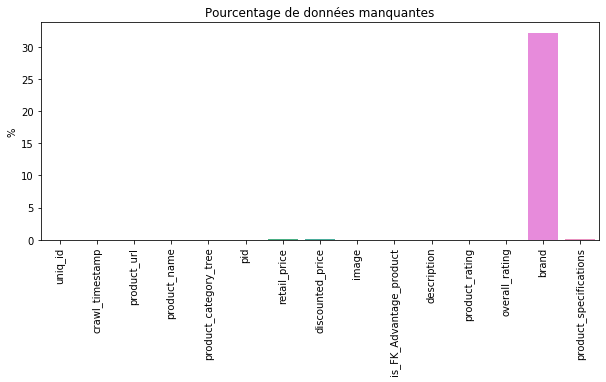

In [6]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()

La feature 'brand' contient plus de 30 % de données manquantes

In [7]:
# Les valeurs manquantes pour la variable "brand" sont remplacés par "".
df["brand"].fillna("", inplace=True)

#### 1.3 Catégories d'images

Chaque image est catégorisée par un système d'arbres avec plusieurs profondeurs. Le nom de la colonne renseignant les catégories est 'product_category_tree'

In [8]:
# Exemple de la catégorie d'un produit
print(df["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


In [9]:
# On récupère la colomne "product_category_tree"
list_categories_1, list_categories_2 = [], []
for txt in df["product_category_tree"] :
    
    list_categories_1.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie
    list_categories_2.append(txt.split(">>")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
df["categories_1"] = pd.Series(list_categories_1)
df["categories_2"] = pd.Series(list_categories_2)

print("Il y a {} catégories dans la pronfondeur 1 et {} categories pour la profondeur 2".format(df["categories_1"].nunique(), df["categories_2"].nunique()))


Il y a 7 catégories dans la pronfondeur 1 et 63 categories pour la profondeur 2


##### Affichage des catégories de la première profondeur

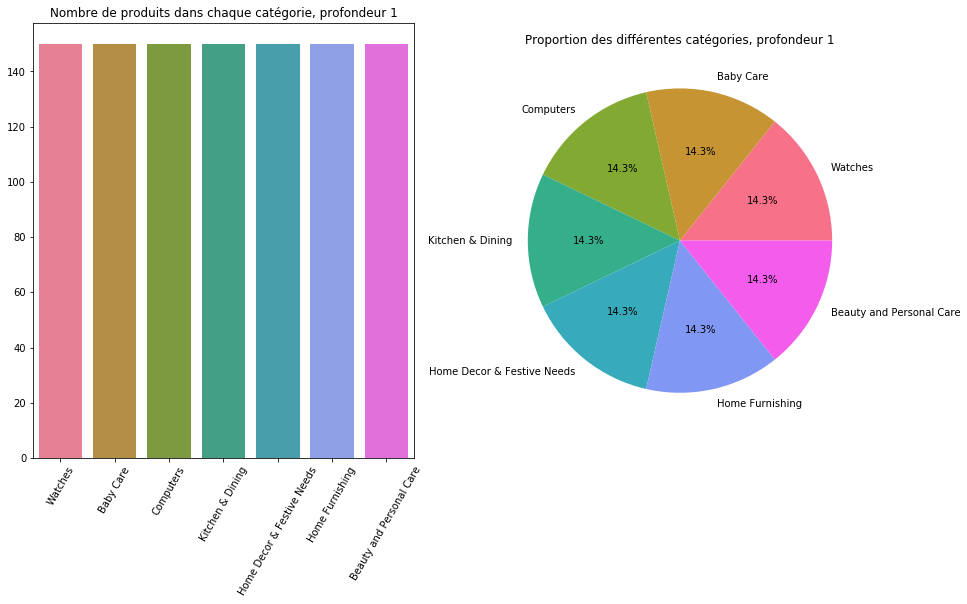

In [10]:
# Histogramme et Pieplot de la répartition des catégories dans la profondeur 1
fig = plt.figure(1, figsize=(15, 8))
categories_1 = df["categories_1"].value_counts()
plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_1)))

# Barplot
plt.subplot(1, 2, 1)
plt.title("Nombre de produits dans chaque catégorie, profondeur 1")

sns.barplot(categories_1.index, categories_1.values, orient="v")
plt.xticks(rotation=60)

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 1")
            
plt.pie(categories_1, labels=list(categories_1.index), autopct='%1.1f%%')
plt.show()

- Il y a 150 images par catégorie de première profondeur

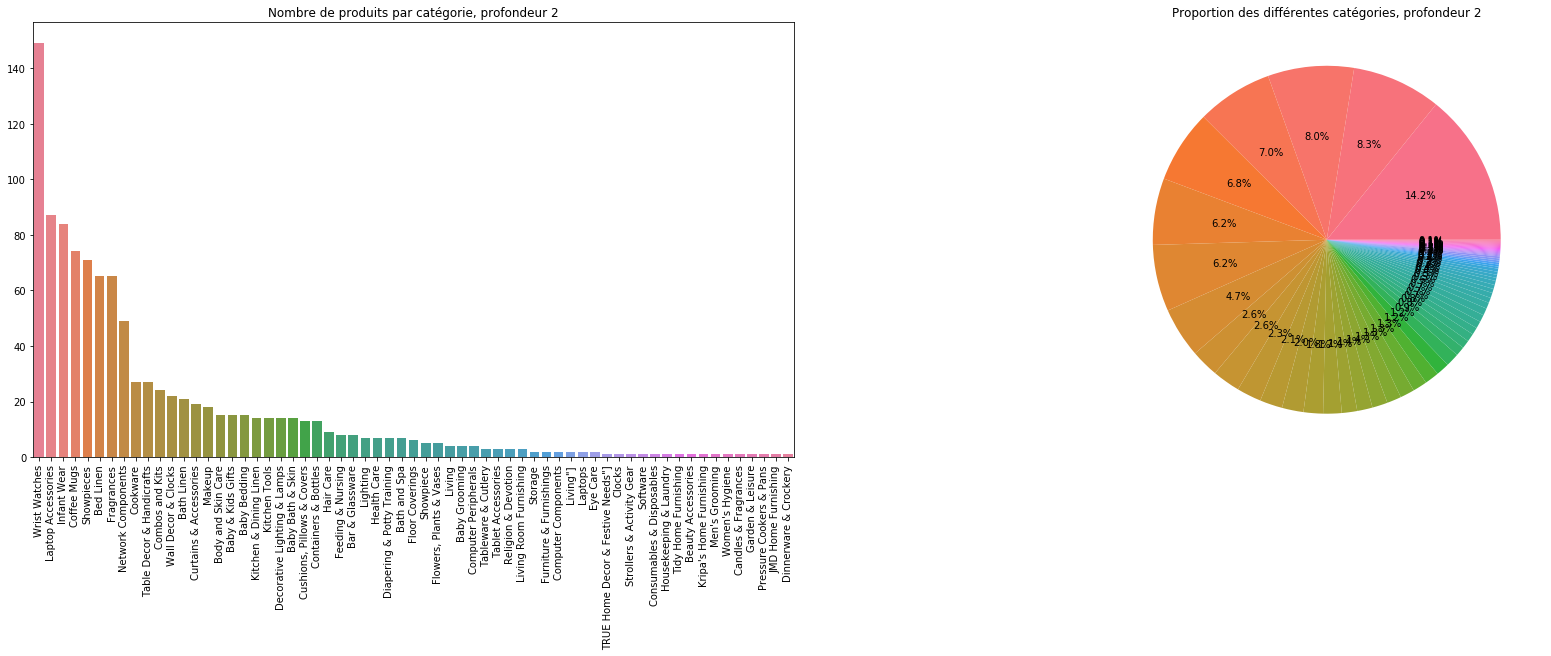

In [11]:
# Histogramme et Pieplot de la répartition des catégories dans la profondeur 2
fig = plt.figure(1, figsize=(30, 8))
categories_2 = df["categories_2"].value_counts()

plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_2)))

# Barplot 
plt.subplot(1, 2, 1)
plt.title("Nombre de produits par catégorie, profondeur 2")

sns.barplot(categories_2.index, categories_2.values, orient="v")
plt.xticks(rotation=90)

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 2")
plt.pie(categories_2, autopct='%1.1f%%')

plt.show()

Il y a 63 catégories différentes pour la profondeur 2 et la répartition des images dans les catégories est très inégale, avec des catégories qui possèdent 149 images contre 1 pour certaines

La profondeur 1 est donc choisie

In [12]:
# Les catégories utilisés pour la résolution du problème de segmentation
categories = df["categories_1"]

#### 1.4 Exemples d'images

Voici un exemple d'image de chaque catégorie (profondeur 1)

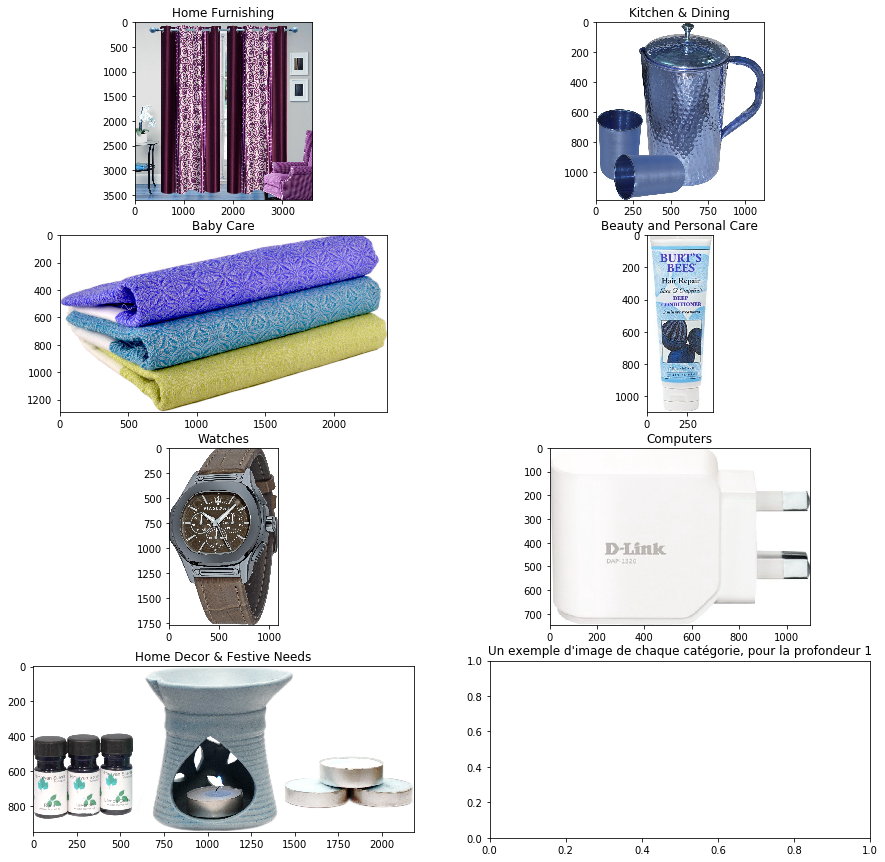

In [13]:
fig, ax = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title("Un exemple d'image de chaque catégorie, pour la profondeur 1")
for i, categ in enumerate(categories.unique()) :
    name_image = df[categories == categ]["image"].iloc[0]
    img = cv2.imread(path + "Images/" + name_image)
    ax[i%4, i//4].set_title(categ)
    ax[i%4, i//4].imshow(img)
  
plt.show()

#### 1.5 Descriptif des articles 

Ci-dessous, vous trouverez un exemple de texte descriptif d'un produit

In [14]:
print("La catégorie du produit est : {} \n".format(categories.iloc[0]))

print("La marque du produit est : {} \n".format(df["brand"].iloc[0]))

print("Le nom du produit est : {} \n".format(df["product_name"].iloc[0]))

print("Le descriptif du produit est : \n \n {}".format(df["description"].iloc[0]))

La catégorie du produit est : Home Furnishing 

La marque du produit est : Elegance 

Le nom du produit est : Elegance Polyester Multicolor Abstract Eyelet Door Curtain 

Le descriptif du produit est : 
 
 Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and 

## 2. Nettoyage des données et pré-traitement des images

#### 2.1 Doublons dans le jeu de données

In [15]:
print("Existe t-il des doublons dans le jeu de données ? {}".format(len(df)!=df["uniq_id"].nunique()))

Existe t-il des doublons dans le jeu de données ? False


#### 2.2 Concaténation des variables textes : "product_name", "description" et "brand"

In [16]:
df["description"] = df["product_name"] + df["brand"] + df["description"]

Toutes les informations textes à notre disposition sont rassemblées dans une unique chaine de caractères (description + nom du produit + marque)

#### 2.3 Pré-traitement des images

Les images sont rendimensionnées en 224*224. Une bande blanche est ajoutée à celles qui ne sont pas carrés.

In [17]:
# Nouvelle dimmension des images
image_size = 224
# Dossier de sauvegarde des images traités
dir_images_transformed = path + "Images_transformed"

In [18]:
def resize2SquareKeepingAspectRation(img, size, interpolation):
    """
    Resize l'image en (size, size) en rajoutant des bandes blanches si nécessaire pour ne pas
    étirer l'image
    
    """
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    if h == w:
        return cv2.resize(img, (size, size), interpolation)
    if h > w:
        dif = h
    else:     
        dif = w
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    if c is None:
        mask = 255*np.ones((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos + h, x_pos:x_pos + w] = img[:h, :w]
    else:
        mask = 255*np.ones((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos + h, x_pos:x_pos + w, :] = img[:h, :w, :]
    return cv2.resize(mask, (size, size), interpolation)

In [13]:
# Vrai ou Faux si les images doivent être pré-traités
preprocess_image = True
Images = []

if preprocess_image:

    for name_img in df["image"] :

        img = Image.open(os.path.join(path + "Images/", name_img)) # Lecture de l'image
        img = ImageOps.autocontrast(img) # Auto contrast
        img = ImageOps.equalize(img) # Egalisation de l'histogramme
        img = img.filter(ImageFilter.BoxBlur(1)) # Lissage pour eliminer le bruit
        img = resize2SquareKeepingAspectRation(np.array(img), image_size, cv2.INTER_AREA) # Resize en 224*224
        Images.append(img)
        img = Image.fromarray(img) # Transforme un array en Image
        img.save(os.path.join(dir_images_transformed, name_img)) # Sauvegarde de l'image

C:\Users\maleg\Anaconda3\lib\site-packages\PIL\Image.py:2766: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [19]:
# Sauvegarde du fichier csv traité
df.to_csv('flipkart_com-ecommerce_sample_1050_1.csv')

## 3. Segmentation

La résolution du problème dans ce projet est un peu particulière car il ne s'agit pas de tenter une classification à partir des données et des étiquettes, mais de faire une segmentation (insupervisée) de nos données et d'en déduire lesquelles appartiennent à une même catégorie.

In [21]:
# Défini les indices d'entrainement et de validation
# pour l'hyperparamétrisation de la cross-validation
skf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# Dictionnaire des résultats, key: nom méthode, value : ARI Score
scores = {}

# Dictionnaire de grid_search pour la conservation des modèles
results_txt = {}
results_img = {}
grid_search_dict = {}
ARI_mean, ARI_std = {}, {}

In [23]:
def define_pipeline(preprocessor, predictor) :
    """
    Assemblage des pipelines pré-traitement des données + clustering
        :preprocessor(transformator) : Transforme les données pour le prédicteur
        :predictor(predictor) : Effectue une prédiction
    
    """

    pipeline = Pipeline([("preprocess", preprocessor),
                         ("predictor", predictor),
                       ])
    return pipeline

### 3.1 Traitement du texte

#### 3.1.1 Méthode Tf-idf

<img src="tf_idf.png">

Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [25]:
# Grille d'hyperparamètres pour le Tf-idf
hyperparameters = {
                   "preprocess__max_df": [0.1, 0.2, 0.5, 0.8],  # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__min_df": [1, 3, 5, 8, 10],  # only keep terms that appear in at least min_df documents
                   "preprocess__ngram_range": [(1, 1), (1, 2)]    
                  }

In [26]:
# Tf-idf avec stops words et n_gram
vect = TfidfVectorizer(
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')

# Pipeline Tf-idf + k-means
pipeline = define_pipeline(vect,  # Tf-idf
                           KMeans(n_clusters=categories.nunique()))  # kmeans

rnd_search = RandomizedSearchCV(pipeline,
                                param_distributions=hyperparameters,
                                scoring='adjusted_rand_score',
                                cv=skf,
                                random_state=0)

# Entrainement du modèle
rnd_search.fit(df["description"].values.astype('U'), categories)

best_model_index = rnd_search.best_index_
ari_score = [rnd_search.cv_results_["split" + str(i) + "_test_score"][best_model_index]
         for i in range(skf.n_splits)]

print("Adjusted Rand Score : {}".format(rnd_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(rnd_search.best_params_))
# Le meilleur score est enregistré dans le dictionnaire des scores
ARI_mean["Text_Tf-idf"] = rnd_search.best_score_
ARI_std["Text_Tf-idf"] = np.std(ari_score)
# Conservation du grid search
grid_search_dict["Text_Tf-idf"] = rnd_search.best_estimator_
results_txt["Text_Tf-idf"] = rnd_search.best_estimator_[0].transform(df["description"].values.astype('U')).toarray()

Adjusted Rand Score : 0.31470629661115784
Les meilleurs paramètres sont : {'preprocess__ngram_range': (1, 1), 'preprocess__min_df': 10, 'preprocess__max_df': 0.5}


In [153]:
# Conversion vecteur creux en vecteur dense
results_txt["Text_Tf-idf"] = results_txt["Text_Tf-idf"].toarray()

In [27]:
tf_idf = rnd_search.best_estimator_[0]
out = tf_idf.transform(df["description"].values.astype('U'))
# Mise sous forme de DataFrame
out_tfidf = pd.DataFrame(out.toarray(), columns=tf_idf.get_feature_names())
# Affichage des 5 premières lignes
out_tfidf.head()

,10,100,12,13,14,15,150,16,17,175,...,womenmaxima,wood,wooden,work,world,wrap,year,years,yellow,yes
0,0.000000,0.046601,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.065151,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.179281,0.070253
2,0.048252,0.087446,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.052069,0.000000,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.054572,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.040182
4,0.000000,0.078399,0.0,0.0,0.0,0.0,0.0,0.000000,0.052568,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.036586


Les colonnes représentent les différents termes retenus par la méthode. Chaque ligne correspond à un descriptif produit. Les valeurs correspondent au calcul du Tf-idf précédement définis

#### 3.1.2 Méthode BoW + LDA

#### Bag-of-words : 

Le bag-of-words consiste à créer une colonne pour chaque mot différent présent pour l'ensemble des textes et d'indiquer le nombre de fois qu'il apparait dans chaque texte. L'histogramme associé consiste à indiquer la fréquence normalisé de l'apparition de chacun des mots dans chaque texte pour l'ensemble du corpus de textes.

#### LDA ( Latent Dirichlet Allocation) :

L’allocation de Dirichlet latente (de l'anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d'expliquer des ensembles d'observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.

Par exemple, si les observations (β) sont les mots collectés dans un ensemble de documents textuels (M), le modèle LDA suppose que chaque document (M) est un mélange (θ) d'un petit nombre de sujets ou thèmes (α topics), et que la génération de chaque occurrence d'un mot (w) est attribuable (probabilité) à l'un des thèmes (t) du document
    

<img src="lda.png">

In [ ]:
# Grille d'hyperparamètres pour le pipeline
# Latent Dirichlet Allocation + KMeans
hyperparameters_bow_lda = {
                   "preprocess__BOW__max_df": [0.1, 0.2, 0.5, 0.8],
                   "preprocess__BOW__min_df": [1, 3, 5],
                   "preprocess__BOW__ngram_range": [(1, 1), (1, 2)]    
                  }

In [28]:
# Grille d'hyperparamètres pour le pipeline
# Latent Dirichlet Allocation + KMeans
hyperparameters_bow_lda = {
                   "preprocess__BOW__max_df": [0.1, 0.2, 0.5, 0.8], # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__BOW__min_df": [1, 3, 5], # only keep terms that appear in at least min_df documents
                   "preprocess__BOW__ngram_range": [(1, 1), (1, 2)]    
                  }

In [29]:
# Pipeline Bag of Words + LDA
bow_lda_pipeline = Pipeline(steps=[
        ('BOW', CountVectorizer(                    
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')), # Bag_of_words
        ('lda', LatentDirichletAllocation(n_components=categories.nunique())),

    ])

In [30]:
pipeline = define_pipeline(bow_lda_pipeline, KMeans(n_clusters=categories.nunique()))

rnd_search = RandomizedSearchCV(pipeline,
                                hyperparameters_bow_lda, # Grille d'hyperparamètres
                                scoring='adjusted_rand_score', # Métrique d'évaluation
                                cv=skf # Découpage du jeu de données en entrainement/validation
                                )

rnd_search.fit(df["description"].values.astype('U'), categories)

best_model_index = rnd_search.best_index_
ari_score = [rnd_search.cv_results_["split" + str(i) + "_test_score"][best_model_index]
         for i in range(skf.n_splits)]

print("Adjusted Rand Score : {}".format(rnd_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(rnd_search.best_params_))

ARI_mean["Text_BOW_LDA"] = rnd_search.best_score_
ARI_std["Text_BOW_LDA"] = np.std(ari_score)

# Conservation du grid search
grid_search_dict["Text_BOW_LDA"] = rnd_search.best_estimator_ # Selection du meilleur estimateur
results_txt["Text_BOW_LDA"] = rnd_search.best_estimator_[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.2806745697181471
Les meilleurs paramètres sont : {'preprocess__BOW__ngram_range': (1, 2), 'preprocess__BOW__min_df': 3, 'preprocess__BOW__max_df': 0.2}


In [31]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [32]:
n_top_words = 10
print("\nTopics in LDA model: ")
tf_feature_names = grid_search_dict["Text_BOW_LDA"][0][0].get_feature_names()
print_top_words(grid_search_dict["Text_BOW_LDA"][0][1], tf_feature_names, n_top_words)


Topics in LDA model: 
Topic #0:
boy baby boy baby pack cotton ideal fabric hair wall pizza
Topic #1:
baby girl baby girl details dress fabric cotton neck set ideal baby
Topic #2:
laptop showpiece battery usb skin set quality prices laptop skin delivery genuine
Topic #3:
combo mugs adapter ceramic warranty mug online rs setflipkart setflipkart com com buy
Topic #4:
watch analog analog watch men watch men india great online rs great discounts india flipkart
Topic #5:
cm showpiece ceramic material mug product inch warranty design gift
Topic #6:
cotton usb light cm products free design single led polyester pack



#### 3.1.3 Méthode Tf-idf + NMF

#### NMF (Non-negative matrix factorization)
c.f le lien ci-joint pour plus d'informations sur la méthodologie :
https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-nmf.pdf

In [119]:
class Normalize(BaseEstimator, TransformerMixin) :
    
    """
    Classe Normalize qui permet de normaliser les données, en utilisant
    la syntaxe des pipelines de sklearn
    """
           
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return normalize(X, norm='l1', axis=1)

In [34]:
# Grille d'hyperparamètres pour Tf-idf + NMF + KMeans
hyperparameters_nmf = {
                   "preprocess__Tf-idf__max_df": [0.1, 0.2, 0.5, 0.8, 0.9], # ignore terms that appear in more than max_df*100% of the documents
                   "preprocess__Tf-idf__min_df": [1, 3, 5, 8, 10], # only keep terms that appear in at least min_df documents
                   "preprocess__Tf-idf__ngram_range": [(1, 2), (1, 3), (1, 4)]    
                  }

In [35]:
# Pipeline Tf-idf + normalize + NMF
nmf_pipeline = Pipeline(steps=[
    ('Tf-idf', TfidfVectorizer(   
                    strip_accents='unicode',
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')), # Tf-idf
    ('normalize', Normalize()),
    ('nmf', NMF(n_components=categories.nunique())),
    ('std_scaler', StandardScaler()),
    ])

In [36]:
pipeline = define_pipeline(nmf_pipeline, KMeans(n_clusters=categories.nunique()))


rnd_search = RandomizedSearchCV(pipeline,
                                hyperparameters_nmf, # Grille d'hyperparamètres
                                scoring='adjusted_rand_score', # 
                                cv=skf,  #Découpage du jeu de données en entrainement/validation
)

rnd_search.fit(df["description"].values.astype('U'), categories)

best_model_index = rnd_search.best_index_
ari_score = [rnd_search.cv_results_["split" + str(i) + "_test_score"][best_model_index]
         for i in range(skf.n_splits)]

print("Adjusted Rand Score : {}".format(rnd_search.best_score_))
print("Les meilleurs paramètres sont : {}".format(rnd_search.best_params_))

ARI_mean["Text_Tf-idf_NMF"] = rnd_search.best_score_ # Meilleur score d'une combinaison d'hyperparamètres
ARI_std["Text_Tf-idf_NMF"] = np.std(ari_score)

# Conservation du grid search
grid_search_dict["Text_Tf-idf_NMF"] = rnd_search.best_estimator_ # Selection du meilleur estimateur
results_txt["Text_Tf-idf_NMF"] = rnd_search.best_estimator_[0].transform(df["description"].values.astype('U'))

Adjusted Rand Score : 0.30554236459357315
Les meilleurs paramètres sont : {'preprocess__Tf-idf__ngram_range': (1, 4), 'preprocess__Tf-idf__min_df': 10, 'preprocess__Tf-idf__max_df': 0.9}


In [37]:
n_top_words = 10
print("\nTopics in NMF model: ")
tf_feature_names = grid_search_dict["Text_Tf-idf_NMF"][0][0].get_feature_names()
print_top_words(grid_search_dict["Text_Tf-idf_NMF"][0][2], tf_feature_names, n_top_words)


Topics in NMF model: 
Topic #0:
showpiece delivery genuine delivery genuine products best prices free cash delivery genuine cash delivery genuine products best prices free shipping shipping cash delivery genuine prices free shipping cash prices free shipping
Topic #1:
genuine products free genuine products free shipping products free products free shipping products free shipping cash com genuine products free blanket abstract single flipkart com genuine products
Topic #2:
watch analog analog watch men watch men analog watch men india flipkart india flipkart com great discounts genuine products discounts genuine products
Topic #3:
hair cm box price price rs type pack color model ml
Topic #4:
usb usb usb led light port usb led led light portable usb led light flexible
Topic #5:
com genuine products 30 combo com flipkart com genuine flipkart com genuine products com genuine products com genuine guarantee free replacement guarantee free replacement guarantee free shipping
Topic #6:
baby g

#### 3.1.4 Méthode Word2Vec

Word2vec est un groupe de modèles utilisé pour le plongement lexical (word embedding).
Ces modèles ont été développés par une équipe de recherche chez Google sous la direction de Tomas Mikolov.
Ce sont des réseaux de neurones artificiels à deux couches entraînés pour reconstruire le contexte linguistique des mots.
La méthode est implémentée dans la bibliothèque Python Gensim. 

<img src="word2vec.png">

#### Nettoyage des données

In [39]:
def cleanText(text):
    # 1. Removing html tags
    #text = BeautifulSoup(text, "lxml").text
    # 2. Removing non-letter.
    text = re.sub("[^a-zA-Z]"," ", text)
    text = text.lower()
    return text

Les caractères autre que les lettres de l'alphabet sont remplacés par des " " et tous les caractères sont mis en miniscule

In [40]:
# This function converts a text to a sequence of words.
def description_wordlist(data, remove_stopwords=False):
    # 1. clean text
    words = cleanText(data).split()
    # 2. Optionally remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))     
        words = [w for w in words if not w in stops]
    return(words)

In [41]:
# This function splits a description into sentences
def description_sentences(data, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer (trailing whitespaces are removed)
    raw_sentences = tokenizer.tokenize(data.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(description_wordlist(raw_sentence,\
                                                  remove_stopwords))

    # This returns the list of lists
    return sentences

# word2vec expects a list of lists.
# Using punkt tokenizer for better splitting of a paragraph into sentences.
import nltk.data
#nltk.download('popular')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Le texte est tokenisé et mis sous forme de 'sentence'

#### Générateur et grille d'hyper-paramètres

In [42]:
# Création d'un générateur de paramètres
def make_generator(parameters):
    if not parameters:
        yield dict()
    else:
        key_to_iterate = list(parameters.keys())[0]
        next_round_parameters = {p: parameters[p]
                                 for p in parameters if p != key_to_iterate}
        for val in parameters[key_to_iterate]:
            for pars in make_generator(next_round_parameters):
                temp_res = pars
                temp_res[key_to_iterate] = val
                yield temp_res

In [90]:
# Nombres de threads
cores = multiprocessing.cpu_count()

# Grille d'hyper-paramètres pour la méthode word2vec
param_grid_w2v = { 
                  'sg': [0, 1],  # CBOW or Skip gram
                  'size': [100, 300], # Nombre de features dans le couche cachée
                  'min_count': [1, 3, 5, 10], # La fréquence minimal de mots pour ne pas être ignoré
                  'window': [3, 5, 10], # nombre de mots dans le contexte
                  'workers': [cores-1]}  # Nombre de 'threads'

In [91]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features, dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [92]:
# Function for calculating the average feature vector
def getAvgFeatureVecs(descriptions, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(descriptions), num_features),dtype="float32")
    for description in descriptions:            
        reviewFeatureVecs[counter] = featureVecMethod(description, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

#### Séléction du meilleur modèle

In [93]:
best_ARI = - float('inf')

for params in make_generator(param_grid_w2v):
    print(params)
    
    # Score ARI
    ARI = []

    # Pour chaque partitionnement du jeu de données
    for train_index, test_index in skf.split(df["description"], df["categories_1"]):
        
        x_train, x_test = df.loc[train_index, 'description'], df.loc[test_index, 'description']
        y_train, y_test = df.loc[train_index, 'categories_1'], df.loc[test_index, 'categories_1']
        
        train_sentences = []
        for description in x_train:
            train_sentences += description_sentences(description, tokenizer, remove_stopwords=True)

        test_sentences = []
        for description in x_test:
            test_sentences += description_sentences(description, tokenizer, remove_stopwords=True)    
        
        # Initialisation du modèle
        w2v_model = Word2Vec(**params)
        w2v_model.build_vocab(train_sentences, progress_per=10000)
        
        # Entrainement du modèle
        w2v_model.train(train_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
        w2v_model.init_sims(replace=True)


        # Calculating average feature vector for training set
        clean_train_descriptions = []
        for description in x_train:
            clean_train_descriptions.append(description_wordlist(description, remove_stopwords=True))
        trainDataVecs = getAvgFeatureVecs(clean_train_descriptions, w2v_model, params["size"])
        
        # Calculating average feature vactors for test set     
        clean_test_descriptions = []
        for description in x_test:
            clean_test_descriptions.append(description_wordlist(description, remove_stopwords=True))
        testDataVecs = getAvgFeatureVecs(clean_test_descriptions, w2v_model, params["size"])

        
        # Segmentation par clustering des résultats
        km = KMeans(n_clusters=categories.nunique())
        km.fit(trainDataVecs)
        clusters = km.predict(testDataVecs)

        # Calcul du score Adjusted Rand Index
        ARI.append(adjusted_rand_score(y_test, clusters))
        
    # Moyenne du score ARI sur les n-passes 
    mean_ARI = np.mean(ARI)
    
        
    print("ARI :", mean_ARI)
    # Si le score est meilleur, il est retenu
    if mean_ARI > best_ARI :
        best_ARI = mean_ARI
        ARI_mean["Word2Vec"] = best_ARI
        ARI_std["Word2Vec"] = np.std(ARI)
        best_params_w2v = params

{'workers': 11, 'window': 3, 'min_count': 1, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3814348172972489
{'workers': 11, 'window': 5, 'min_count': 1, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.34395958933141524
{'workers': 11, 'window': 10, 'min_count': 1, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3172726044051867
{'workers': 11, 'window': 3, 'min_count': 3, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.38845963864978633
{'workers': 11, 'window': 5, 'min_count': 3, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.34595717560218847
{'workers': 11, 'window': 10, 'min_count': 3, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.2957786365715299
{'workers': 11, 'window': 3, 'min_count': 5, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.34884311266976376
{'workers': 11, 'window': 5, 'min_count': 5, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3489916706595726
{'workers': 11, 'window': 10, 'min_count': 5, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.29088736618283706
{'workers': 11, 'window': 3, 'min_count': 10, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3085042250675779
{'workers': 11, 'window': 5, 'min_count': 10, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3035365489265975
{'workers': 11, 'window': 10, 'min_count': 10, 'size': 100, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.28831774377725267
{'workers': 11, 'window': 3, 'min_count': 1, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3883602351266884
{'workers': 11, 'window': 5, 'min_count': 1, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.35194768857783243
{'workers': 11, 'window': 10, 'min_count': 1, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3135182680887896
{'workers': 11, 'window': 3, 'min_count': 3, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.38673782672203993
{'workers': 11, 'window': 5, 'min_count': 3, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.32755296279431806
{'workers': 11, 'window': 10, 'min_count': 3, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.30124530301798613
{'workers': 11, 'window': 3, 'min_count': 5, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.34381191273109135
{'workers': 11, 'window': 5, 'min_count': 5, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.31241000554722764
{'workers': 11, 'window': 10, 'min_count': 5, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.2911193658011665
{'workers': 11, 'window': 3, 'min_count': 10, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.321064855397002
{'workers': 11, 'window': 5, 'min_count': 10, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.2992659082655941
{'workers': 11, 'window': 10, 'min_count': 10, 'size': 300, 'sg': 0}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3015441392691744
{'workers': 11, 'window': 3, 'min_count': 1, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3993358008861977
{'workers': 11, 'window': 5, 'min_count': 1, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3712990991171056
{'workers': 11, 'window': 10, 'min_count': 1, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3433039820833862
{'workers': 11, 'window': 3, 'min_count': 3, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.36626974915181804
{'workers': 11, 'window': 5, 'min_count': 3, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3514180115617807
{'workers': 11, 'window': 10, 'min_count': 3, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.33838236352040896
{'workers': 11, 'window': 3, 'min_count': 5, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3408604185657514
{'workers': 11, 'window': 5, 'min_count': 5, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.32726890219349025
{'workers': 11, 'window': 10, 'min_count': 5, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.30900163334571185
{'workers': 11, 'window': 3, 'min_count': 10, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3282921309033355
{'workers': 11, 'window': 5, 'min_count': 10, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.289973660799429
{'workers': 11, 'window': 10, 'min_count': 10, 'size': 100, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3085170605462931
{'workers': 11, 'window': 3, 'min_count': 1, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.38516556598477086
{'workers': 11, 'window': 5, 'min_count': 1, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3584338995444972
{'workers': 11, 'window': 10, 'min_count': 1, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3569324264529526
{'workers': 11, 'window': 3, 'min_count': 3, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3648950643462418
{'workers': 11, 'window': 5, 'min_count': 3, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3535169889892175
{'workers': 11, 'window': 10, 'min_count': 3, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.34259187555528403
{'workers': 11, 'window': 3, 'min_count': 5, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.35222593717351625
{'workers': 11, 'window': 5, 'min_count': 5, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.31296307003426543
{'workers': 11, 'window': 10, 'min_count': 5, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3247035399809003
{'workers': 11, 'window': 3, 'min_count': 10, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.3325774317854686
{'workers': 11, 'window': 5, 'min_count': 10, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.32601783441293486
{'workers': 11, 'window': 10, 'min_count': 10, 'size': 300, 'sg': 1}


C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use 

ARI : 0.29621640705009095


Le meilleur modèle est ensuite entrainé sur tout le jeu d'entrainement et les résultats sont stockées dans un dictionnaire

In [95]:
# Nettoyage des données et mise sous forme de 'Sentence'
sentences = []
for description in df["description"]:
    sentences += description_sentences(description, tokenizer, remove_stopwords=True)

# Initialisation du modèle
w2v_model = Word2Vec(**best_params_w2v)
w2v_model.build_vocab(sentences, progress_per=10000)

# Entrainement du modèle
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

# Calculating average feature vactors for all data    
clean_descriptions = []
for description in df["description"]:
    clean_descriptions.append(description_wordlist(description, remove_stopwords=True))
AllDataVecs = getAvgFeatureVecs(clean_descriptions, w2v_model, best_params_w2v["size"])

# Conservation du grid search
grid_search_dict["Word2Vec"] = w2v_model # Selection du meilleur estimateur
results_txt["Word2Vec"] = AllDataVecs

C:\Users\maleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


#### 3.1.5 Méthode doc2vec

La méthode doc2vec est un dérivé de la méthode word2vec à laquelle on ajoute la feature "Document Id"

<img src="doc2vec.png">

#### Grille d'hyper-paramètres

In [64]:
param_grid_d2v = { 
                  'dm': [0, 1],  # 0: PV-DBOW, 1: PV-DM,
                  'min_count': [1, 2, 5],
                  'sample': [0], # the threshold for configuring which higher-frequency words are randomly down sampled
                  'vector_size': [100, 300], # Nombre de features de la couche cachée
                  'negative': [2, 5],
                  'workers': [cores-1]}

#### Nettoyage des données

In [65]:
# La méthode cleanText est appliqué à chaque description de produits
df_clean = df.copy()
df_clean["description"] = df_clean["description"].apply(cleanText)

#### Tokenisation et taggage des documents

In [62]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [63]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    x, y = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return x, y

#### Séléction du meilleur modèle

In [66]:
best_ARI = - float('inf')

for params in make_generator(param_grid_d2v):
    print(params)
    
    # Score ARI
    ARI = []
    
    # Pour chaque partitionnement du jeu de données
    for train_index, test_index in skf.split(df_clean["description"], df_clean["categories_1"]):
        
        x_train_tagged = df_clean.apply(
                    lambda r: TaggedDocument(words=tokenize_text(r["description"]),
                                             tags=[r["categories_1"]]), axis=1)

        x_test_tagged = df_clean.apply(
                    lambda r: TaggedDocument(words=tokenize_text(r["description"]),
                                             tags=[r["categories_1"]]), axis=1)  
        
        # Initialisation du modèle
        d2v_model = doc2vec.Doc2Vec(**params)
        d2v_model.build_vocab([x for x in tqdm(x_train_tagged.values)])

        # Entrainement du modèle
        d2v_model.train(x_train_tagged, total_examples=d2v_model.corpus_count, epochs=50, report_delay=1)
        d2v_model.init_sims(replace=True)


        # Prédiction sur le jeu Test
        y_train, ouput_train = vec_for_learning(d2v_model, x_train_tagged)
        y_test, output_test = vec_for_learning(d2v_model, x_test_tagged)

        
        # Segmentation par clustering des résultats
        km = KMeans(n_clusters=categories.nunique())
        km.fit(ouput_train)
        clusters = km.predict(output_test)

        # Calcul du score Adjusted Rand Index
        ARI.append(adjusted_rand_score(y_test, clusters))
        
    # Moyenne du score ARI sur les n-passes 
    ARI = np.mean(ARI)
    
    print("ARI :", mean_ARI)
    # Si le score est meilleur, il est retenu
    if mean_ARI > best_ARI :
        best_ARI = mean_ARI
        ARI_mean["Doc2Vec"] = mean_ARI
        ARI_std["Doc2Vec"] = np.std(ARI)
        best_params_d2v = params

{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 1, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.94485987043414
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 1, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.9435619770289374
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 1, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1055866.51it/s]


ARI : 0.9462065310348363
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 1, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.9325435249363065
{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 2, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1020866.76it/s]


ARI : 0.9454818876474056
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 2, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1068936.70it/s]


ARI : 0.9199173169784638
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 2, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1087412.15it/s]


ARI : 0.9421525498181922
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 2, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1052837.49it/s]


ARI : 0.9209189198386623
{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 5, 'dm': 0}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1054349.82it/s]


ARI : 0.7950214996674088
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 5, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.7612341023997569
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 5, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.7835636610796513
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 5, 'dm': 0}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.7655468673100596
{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 1, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.034758103686560335
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 1, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.04692130628205674
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 1, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.0336684793360069
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 1, 'dm': 1}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1052082.94it/s]


ARI : 0.04544413403798033
{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 2, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.04206774574309359
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 2, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.061763124593381014
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 2, 'dm': 1}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1025621.61it/s]


ARI : 0.04249186361474627
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 2, 'dm': 1}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1053593.11it/s]


ARI : 0.04737304773382318
{'workers': 11, 'negative': 2, 'vector_size': 100, 'sample': 0, 'min_count': 5, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.04376143788801125
{'workers': 11, 'negative': 5, 'vector_size': 100, 'sample': 0, 'min_count': 5, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.08638425461300238
{'workers': 11, 'negative': 2, 'vector_size': 300, 'sample': 0, 'min_count': 5, 'dm': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


ARI : 0.043696940470293835
{'workers': 11, 'negative': 5, 'vector_size': 300, 'sample': 0, 'min_count': 5, 'dm': 1}


100%|█████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1075462.56it/s]


ARI : 0.08126071210441047


Le meilleur modèle est ensuite entrainé sur tout le jeu d'entrainement et les résultats sont stockées dans un dictionnaire

In [69]:
# Nettoyage des données et tag
x_tagged = df_clean.apply(
            lambda r: TaggedDocument(words=tokenize_text(r["description"]),
                            tags=[r["categories_1"]]), axis=1)

# Initialisation du modèle
d2v_model = doc2vec.Doc2Vec(**best_params_d2v)
d2v_model.build_vocab([x for x in tqdm(x_tagged.values)])

# Entrainement du modèle
d2v_model.train(x_tagged, total_examples=d2v_model.corpus_count, epochs=50, report_delay=1)
d2v_model.init_sims(replace=True)

# Prédiction sur tout le jeu de données
y, output = vec_for_learning(d2v_model, x_tagged)

# Conservation du grid search
grid_search_dict["Doc2Vec"] = d2v_model # Selection du meilleur estimateur
results_txt["Doc2Vec"] = np.array(output)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<?, ?it/s]


### 3.2 Traitement des images

#### 3.2.1 Utilisation de SIFT sur chacune des 1050 images

La méthodoligie d'extraction de features par SIFT se fait en 4 étapes :

   -  Récupérer les descripteurs de chaque image par un algorithme de type SIFT
   -  Clusteriser l'ensemble de tous les descripteurs
   -  Associer les descripteurs de chaque image aux centres obtenus par clustering

<img src="kmeans_sift.png">

   -  Faire un bag of words des descripteurs de chaque image, pour toutes les images

<img src="bovw_sift_kmeans.png">

##### Fonction pour l'algorithme SIFT

In [97]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):

    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

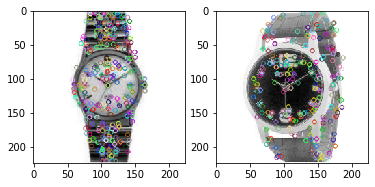

In [98]:
# Exemple 1 d'une image
image_1 = cv2.imread(os.path.join(dir_images_transformed, '71ff6abd7764f2a42fcbefc11429be2d.jpg'))
# Exemple 2 d'une image
image_2 =  cv2.imread(os.path.join(dir_images_transformed, 'dd0e3470a7e6ed76fd69c2da27721041.jpg'))
gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

#create sift object
sift  = cv2.xfeatures2d.SIFT_create()
#calculate keypoints and their orientation
keypoints_1, descriptors_1 = sift.detectAndCompute(gray_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray_2, None)

#plot keypoints on the image
with_keypoints_1 = cv2.drawKeypoints(gray_1, keypoints_1, outImage=gray_1)
with_keypoints_2 = cv2.drawKeypoints(gray_2, keypoints_2, outImage=gray_2)

#plot the image
fig, ax = plt.subplots(1, 2)

# Affichage des descripteurs Sift dans les deux images
ax[0].imshow(with_keypoints_1)
ax[1].imshow(with_keypoints_2)

plt.show()

La localisation des descripteurs des deux images ci-dessus est représenté par les ronds de couleur

##### Récupération des descripteurs de chaque image

In [103]:
def sift_features_centers(df, categories, n_centers, dir_images=dir_images_transformed) :
    
    """
    Pour chaque image, applique l'algorithme SIFT pour détecter les descripteurs.
    Ensuite, un k-means est appliqué sur l'ensemble de tous les descripteurs
    puis pour chaque image prise individuellement, k-means prédit pour chaque descripteur le centre associé
    Retourne une liste de liste, lenght=nombre d'images et pour chaque image correspond une liste dont
    la taille est égale au nombre de descripteurs détectés par l'algorithme SIFT
    df(pd.DataFrame): contient 'image' qui correspond au nom de l'image, 'categories' qui est l'étiquette
    de chaque produit
    n_centers(int): correspond au nombre de centres de descripteurs
    dir_image(str): chemin d'accès aux images (pour leur lecture)
    """
    
    images = []
    labels = []
    descripteurs = []
    index_to_del = []
    images_desc = []

    for index, image_name in df["image"].iteritems() : # Pour chaque image du jeu de données

        image = cv2.imread(os.path.join(dir_images, image_name)) # Lecture de l'image
        kp, desc = gen_sift_features(image) # Keypoints et descripteurs de l'image

        if (desc is not None) : # Si desc est différent de None
            images.append(np.array(image)) 
            for d in desc : # Pour chaque descripteur de l'image
                # Ajoute chaque descripteur de l'image dans une grande matrice de descripteurs
                descripteurs.append(normalize(d.reshape(1, -1)).ravel()) 
            labels.append(categories.loc[index])
            images_desc.append(normalize(desc))
        else :
            print("Descriptors of Image n° {} is None".format(index))
            index_to_del.append(index)


    descripteurs = np.array(descripteurs)
    labels = np.array(labels)

    km = KMeans(n_clusters=n_centers)

    km.fit(descripteurs)
    centers = []

    for desc in images_desc :
        centers.append(km.predict(desc))
    
    return centers

##### Construction de l'histogramme

In [135]:
class Build_histogram(BaseEstimator, TransformerMixin) :
    """
    Transformateur en histogramme
    Chaque colonne représente un mot et sa fréquence associée
    
    """
    
    def __init__(self, n_centers):
        self.n_centers = n_centers
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):     
        result = np.array([[list(X[i]).count(k) for k in range(0, self.n_centers)] for i in range(len(X))])
        return result

#### 3.2.2 Clustering des descripteurs 

In [ ]:
# Détermine les différents descripteurs de chaque image
# Clustering de l'ensemble des descripteurs
# Pour chaque image, associe chaque descripteur
# à un des centres obtenus par clustering
X = sift_features_centers(df, categories, n_centers=500)

In [133]:
# Pipeline Histogramme + Normalize
sift_pipeline = Pipeline(steps=[
        ('Build_histogram', Build_histogram(n_centers=500)), # Bag_of_visual_words
        ('normalize', Normalize()) # Normalisation de l'histogramme
    ])

# KMeans est rajouté au pipeline pour la segmentation
pipeline = define_pipeline(sift_pipeline, KMeans(n_clusters=categories.nunique()))

In [141]:
score = cross_val_score(pipeline,
                        X, # Réduction de dimensions + k-means
                        categories,
                        scoring='adjusted_rand_score',
                        cv=skf) # 5 passes

ARI_std['img_Sift_BoVW'] = np.std(score)
ARI_mean['img_Sift_BoVW'] = np.mean(score)

results_img['img_Sift_BoVW'] = sift_pipeline.fit_transform(X)

In [144]:
print("Le score ARI de la méthode sift est de :", ARI_mean['img_Sift_BoVW'])

Le score ARI de la méthode sift est de : 0.02826765000965615


Ce score est mauvais, la méthode n'est donc pas exploitable.

#### 3.2.2 Transfert Learning

L'architecture complexe du Resnet50 est détaillé ci-dessous. Dans cette partie, nous utilisons ce réseau pré-entrainé en extrayant le résultat de la dernière couche appliqué à nos données. A cette dernière couche, est appliqué un algorithme de réduction de dimensions. La méthode k-means permet ensuite de définir des clusters correspondant aux catégories d'images présentes dans notre jeu de données.

<img src="resnet.png">

In [145]:
# Initilisation du réseau de neurones
model = Sequential()

# Ajout des poids à partir de resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
model.add(ResNet50(include_top=False,
                   pooling='avg',
                   weights='imagenet',
                   input_shape=(image_size, image_size, 3)))

In [146]:
# Résumé du réseau de neurones: détail de chaque couche
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [147]:
# Jeu d'entrainement
X = np.array([np.array((os.path.join(dir_images_transformed, name_image))) for name_image in df["image"]])
# Création de répertoires d'images avec les noms des différentes catégories
for x, y, name_image in zip(X, categories, df["image"]) :
    new_dir = dir_images_transformed + y # Nouveau dossier de sauvegarde
    if not os.path.exists(new_dir):
         os.makedirs(new_dir) # Check si le dossier existe ou non
    img = Image.open(x) # Lecture de l'image
    img.save(os.path.join(new_dir, name_image)) # Sauvegarde dans le dossier de la catégorie associée
    
BATCH_SIZE_TRAINING = 1050
# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
                    dir_images_transformed,
                    target_size=(image_size, image_size),
                    batch_size=BATCH_SIZE_TRAINING,
                    class_mode='categorical')

Found 1050 images belonging to 7 classes.


In [148]:
run = False
if run :
    # Prédiction par réseau neuronal
    output_cnn = model.predict_generator(train_generator)
    # Sauvegarde de la sortie du réseau
    pickle.dump(output_cnn, open('output_cnn_resnet50.h5', 'wb'))
else :
    # Lecture de la sortie du réseau
    output_cnn = pickle.load(open('output_cnn_resnet50.h5', 'rb'))

In [149]:
# Méthodologies de réduction de dimmension
reduce_dim = {  
                "PCA": Pipeline(steps=[
                        ('pca', PCA()),
                        ('std_scaler', StandardScaler())
                        ]),
                "NMF": Pipeline(steps=[
                        ('normalize', Normalize()),
                        ('nmf', NMF()),
                        ('std_scaler', StandardScaler()),
                        ])
}


hyperparameters_pca = {
                    "preprocess__pca__n_components": [0.7, 0.8, 0.9, 0.95]  # Ratio de variance à conserver
}


hyperparameters_nmf = {
                    "preprocess__nmf__n_components": [15, 20, 25, 50, 75, 100]  # nombre de dimensions à conserver
}



hyperparameters = {
                    "PCA": hyperparameters_pca,
                    "NMF": hyperparameters_nmf
}


In [150]:
def make_positive(matrix):
    """
    Rend non négative une matrice en ajoutant le minimum
    de chaque ligne si la ligne contient au moins une valeur négative
    """
    
    def make_positive_col(col):
        col_min = np.min(col)
        if col_min < 0 :
            positive_col = col - col_min
            return positive_col
        elif col_min >=0:
            return col
    
    if (matrix>=0.0).all():
        return matrix
    else :
        positive_mat = np.apply_along_axis(make_positive_col,
                                           axis=1,
                                           arr=matrix)
        return positive_mat

In [152]:
for name_prepro, preprocessor in reduce_dim.items() :
    # Combinaison de l'algo de réduction avec k-means
    pipeline = define_pipeline(preprocessor, KMeans(n_clusters=categories.nunique()))
    
    grid_search = GridSearchCV(pipeline, # Réduction de dimensions + k-means
                               param_grid=hyperparameters[name_prepro], # Grille de paramètres
                               scoring='adjusted_rand_score', # ARI métrique
                               cv=skf, # 10 passes
                              ) 
    
    if name_prepro == "NMF" :
        # Rend la matrice non négative pour l'application de NMF
        X = make_positive(output_cnn)
    else :
        X = output_cnn
       
        
    # Entrainement du modèle    
    grid_search.fit(X, categories)
    
    best_model_index = grid_search.best_index_
    ari_score = [grid_search.cv_results_["split" + str(i) + "_test_score"][best_model_index]
         for i in range(skf.n_splits)]
    
    print("Le score ARI avec la méthode de réduction de dimmension {} est de : {}".format(name_prepro,
                                                                                          np.mean(ari_score)))
    print(grid_search.best_params_)
    ARI_mean["img_CNN_" + name_prepro] = grid_search.best_score_
    ARI_std["img_CNN_" + name_prepro] = np.std(ari_score)
    # Conservation du grid search
    grid_search_dict["img_CNN_" + name_prepro] = grid_search.best_estimator_[0]
    results_img["img_CNN_" + name_prepro] = grid_search.best_estimator_[0].transform(X)

Le score ARI avec la méthode de réduction de dimmension PCA est de : 0.0028078075742082845
{'preprocess__pca__n_components': 0.8}
Le score ARI avec la méthode de réduction de dimmension NMF est de : 0.004755920817915756
{'preprocess__nmf__n_components': 75}


La méthode de réduction par NMF offre les meilleurs résultats avec un score ARI de 0.005. Ce résultat est cependant très mauvais.

### 3.3 Concaténation des données textes et images

Les données sont concaténées puis normalisées

In [155]:
# Pour chaque méthode de traitement des  images
for name_method_img, data_img in results_img.items() : 
    # Pour chaque méthode de traitement des textes
    for name_method_text, data_text in results_txt.items() :
        # Concaténation du nom des deux méthodes
        name_method = name_method_text + " & " + name_method_img
        # Concaténation des données textes et images
        X_concat = np.concatenate((data_text, data_img), axis=1)
        # Normalisation des données
        X_std = StandardScaler().fit_transform(X_concat) 
        
        # calculdu score
        score = cross_val_score(KMeans(n_clusters=categories.nunique()),
                                X_std, # Données
                                categories,  # Etiquettes,
                                scoring='adjusted_rand_score', # ARI score
                                cv=skf,  # Partitionnement des données
                                n_jobs=-1)
        
        # calcul du score moyen et de l'écart type de la cross-validation
        ARI_mean[name_method], ARI_std[name_method] = score.mean(), score.std()

### 3.4 Résultats et visualisation graphique

#### 3.4.1 Adjusted Rand Score 

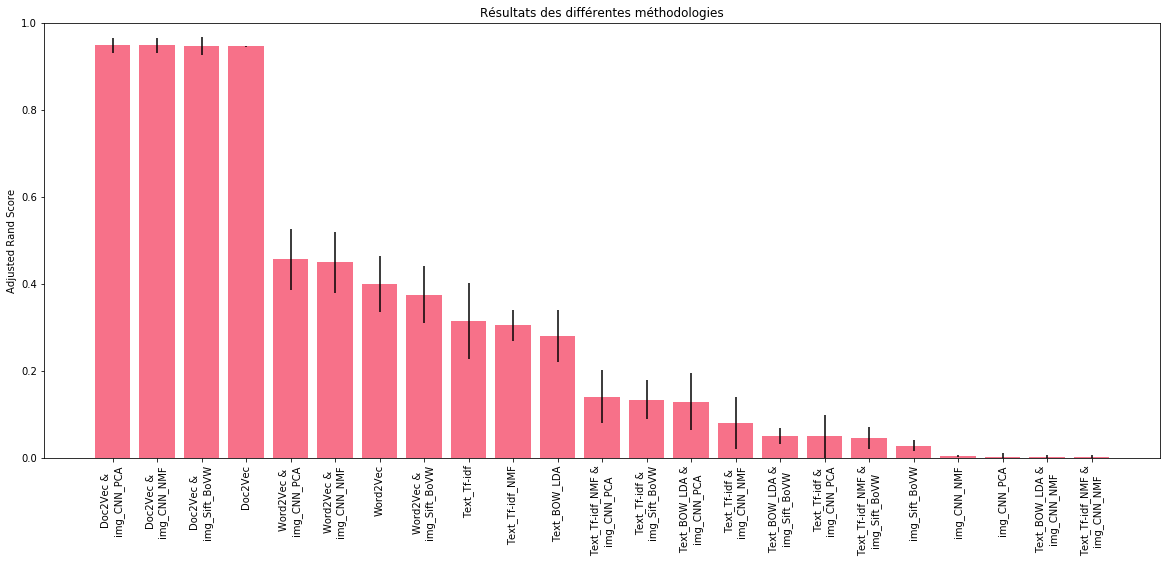

In [160]:
mean_ARI_values = []
ARI_keys = []
std_ARI_values = []
# Le dictionnaire de résultat est trié par ordre décroissant des valeurs
for k, v in sorted(ARI_mean.items(), key=lambda x: x[1], reverse=True):
    mean_ARI_values.append(v)
    ARI_keys.append(k)
    std_ARI_values.append(ARI_std[k])

# Tracer la figure ARI en fonction des différentes méthodologies
fig = plt.figure(1, figsize=(20, 8))
plt.bar(range(len(mean_ARI_values)), mean_ARI_values, align='center')
plt.errorbar(range(len(std_ARI_values)), mean_ARI_values, yerr=std_ARI_values, fmt='none', ecolor='black')

plt.ylim([0, 1])
plt.ylabel('Adjusted Rand Score')
plt.title("Résultats des différentes méthodologies")
labels = [ '\n'.join(wrap(l, 20)) for l in ARI_keys ]
plt.xticks(range(len(labels)), labels, rotation='vertical')

plt.show()

Il apparait qu'une concaténation des résultats images avec les résultats texts permet d'augmenter très légèrement les résultats de la meilleur méthodologie de traitement du texte, au prix cependant d'une variance assez importante.

"Doc2Vec" est donc de loin la meilleur méthode et il est préférable de l'utiliser seule.

#### 3.4.2 Matrice de Confusion

Les labels sont encodés numériquement

In [166]:
# Les catégories d'images sont encodés numériquement de 0 à 6
cat_encoder = LabelEncoder()
y = cat_encoder.fit_transform(categories)

In [162]:
# Labels prédits par le meilleur algorithme
km = KMeans(n_clusters=categories.nunique())
labels_pred = km.fit_predict(results_txt["Doc2Vec"])

Calcul de la matrice de confusion

In [168]:
# Calcul de la Matrice de confusion
mat_conf = confusion_matrix(y, labels_pred)
# Mise sous forme de DataFrame
mat_conf_df = pd.DataFrame(mat_conf, index=cat_encoder.classes_, columns=range(len(categories.unique())))

Affichage graphique de la matrice de confusion

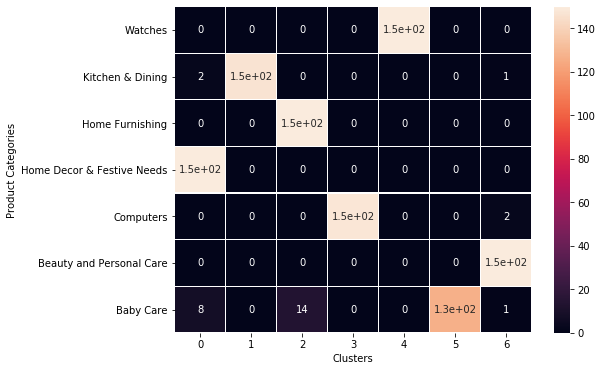

In [169]:
# Trace la matrice de confusion
fig = plt.figure(1, figsize=(8, 6))
sns.heatmap(mat_conf_df, annot=True, linewidths=.3)
plt.ylabel('Product Categories')
plt.xlabel('Clusters')
plt.ylim(0, 7)
plt.show()

Les produits sont très bien segmentés. On note cependant quelques erreurs de segmentation pour les produits "Baby Care".

#### 3.4.3 Projection 2D via TSNE

L'algorithme de t-SNE (t-distributed stochastic neighbor embedding) est une technique de réduction de dimension pour la visualisation de données.

Il s'agit d'une méthode non-linéaire permettant de représenter un ensemble de points d'un espace à grande dimension dans un espace à deux ou trois dimensions.

L'algorithme t-SNE tente de trouver  une configuration optimale selon un critère de théorie de l'information pour respecter les proximités entre points : deux points qui sont proches (resp. éloignés) dans l'espace d'origine devront être proches (resp. éloignés) dans l'espace de faible dimension.

L'algorithme t-SNE se base sur une interprétation probabiliste des proximités. Une distribution de probabilité est définie sur les paires de points de l'espace d'origine de telle sorte que des points proches l'un de l'autre ont une forte probabilité d'être choisis tandis que des points éloignés ont une faible probabilité d'être sélectionnés. Une distribution de probabilité est également définie de la même manière pour l'espace de visualisation. L'algorithme t-SNE consiste à faire concorder les deux densités de probabilité, en minimisant la divergence de Kullback-Leibler entre les deux distributions par rapport à l'emplacement des points sur la carte.

In [177]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(50, 40)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for i, digit in enumerate(digits):
        sns.scatterplot(X_normalized[y == digit, 0],
                        X_normalized[y == digit, 1],
                        c=[cmap(i / 7)],
                        label=digit)
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.title("Projection 2D par TSNE")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            
    plt.legend(loc='upper right')

In [173]:
# Algorithme de TSNE : réduction de dimmensions
tsne = TSNE()
# Transforme l'espace de départ en un espace d'arrivé
# à deux dimmensions
X_tsne = tsne.fit_transform(results_txt["Doc2Vec"])

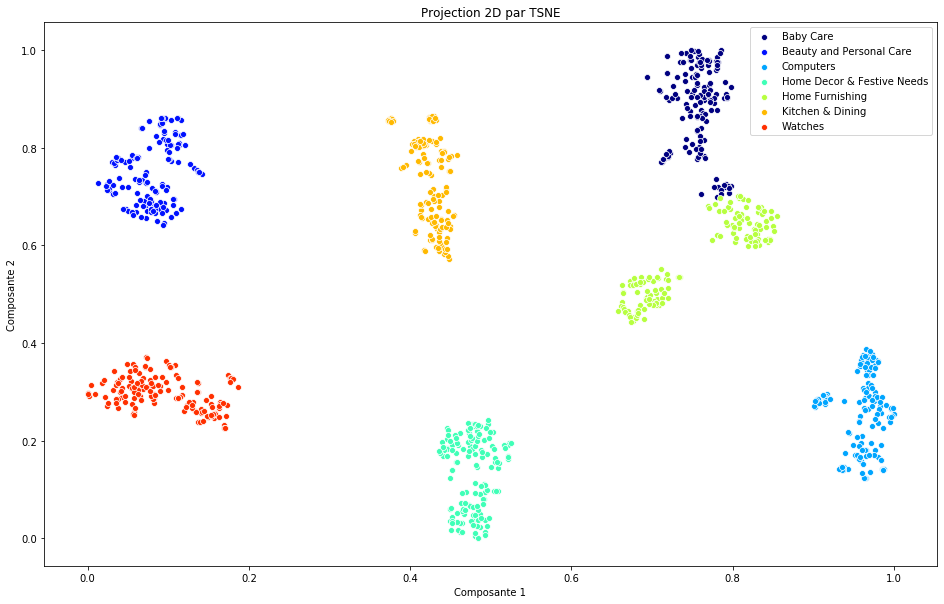

In [179]:
# Affichage graphique des résultats de la TSNE
plot_digits(X_tsne, categories.values, figsize=(16, 10))

Ce graphique représente une projection 2D par TSNE des features de notre meilleur méthodologie. Il illustre la possibilité d'une classification, puisqu'il apparait une sépération visuelle très franche des différentes catégories de produits.

## 4. "Data Augmentation" avec requêtes Amazon

### Requête Amazon

In [ ]:
from amazon.api import AmazonAPI

amazon = AmazonAPI(
    AMAZON_ACCESS_KEY,
    AMAZON_SECRET_KEY,
    AMAZON_ASSOC_TAG,
    region="US" # Région du monde
                  )

products = amazon.search_n(
    100, # Nombre de produits
    Keywords='computers', # Types de produits
    SearchIndex='All')

for i, product in enumerate(products):
    print "{0}. '{1}'".format(i, product.title)